# Analysis of Monthly Mean Hydrologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Total Runoff
- ET

In [2]:
from loca import print_date
print_date()

Last executed: 2019-06-19 12:26:00.461543 by jvano on r6i6n31


# Imports and Options

In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

# models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3'] #JAV: CNRM_CM5 has an issue
# models = ['ACCESS1-0', 'CanESM2']
models = ['MIROC5', 'MRI-CGCM3']
# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']

#JAV: without issue
# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']

hydro_vars = ['ET', 'total_runoff', 'SWE']
# hydro_vars = ['ET']

In [4]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
# client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client

<Client: scheduler='tcp://10.148.10.15:56251' processes=36 cores=144>

# Load Data

In [5]:
xr.set_options(file_cache_maxsize=12000)
hist_data = load_monthly_cmip_hydro_datasets('historical', models=models, autoclose=False, parallel=True)
rcp4_data = load_monthly_cmip_hydro_datasets('rcp45', models=models, autoclose=False, parallel=True)
rcp8_data = load_monthly_cmip_hydro_datasets('rcp85', models=models, autoclose=False, parallel=True)

# JAV got error: cannot reindex or align along dimension 'lon' because the index has duplicate values when included 
# all three lines above, I think the error has more to do with a particular GCM than.  when just two, it appeared to work

load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology
load_monthly_bcsd_hydrology
load_bcsd_dataset
load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology
load_monthly_bcsd_hydrology
load_bcsd_dataset
load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology
load_monthly_bcsd_hydrology
load_bcsd_dataset


In [6]:
write_cache = False

if write_cache:
    for key, ds in hist_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro.{key}_{gcm}.nc'))
        

In [7]:
read_cache = True
hist_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        


In [10]:
hist_data
# hist_data.items()

{'loca': <xarray.Dataset>
 Dimensions:       (gcm: 2, lat: 224, lon: 464, time: 672)
 Coordinates:
   * lat           (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
   * lon           (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
   * time          (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
   * gcm           (gcm) <U9 'MIROC5' 'MRI-CGCM3'
 Data variables:
     ET            (gcm, time, lat, lon) float32 dask.array<shape=(2, 672, 224, 464), chunksize=(1, 72, 224, 464)>
     total_runoff  (gcm, time, lat, lon) float32 dask.array<shape=(2, 672, 224, 464), chunksize=(1, 72, 224, 464)>
     SWE           (gcm, time, lat, lon) float32 dask.array<shape=(2, 672, 224, 464), chunksize=(1, 72, 224, 464)>,
 'bcsd': <xarray.Dataset>
 Dimensions:       (gcm: 2, lat: 222, lon: 462, time: 672)
 Coordinates:
   * lon           (lon) float32 -124.6875 -124.5625 ... -67.1875 -67.0625
   * time          (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01


In [11]:
hist_epoch = slice('1969-01-01', '1999-12-31')
futr_epoch = slice('2069-01-01', '2099-12-31')

mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

hist_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data.items())
rpc4_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data.items())

# commented out just to see if could get figs to run JAV - I think the error has more to do with a particular GCM than.  when just two, it appeared to work
rpc8_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data.items())


# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [36]:
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 800},}
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]
# subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means)]

In [37]:
# JAV attempts to plot ensemble averages

# subcols = [('Historical', hist_means)]
# hydro_vars = ['total_runoff']

# for var in hydro_vars:
    
#         fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 4*len(models)))
        
#         for row, model in enumerate(models):
#             for i, dset in enumerate(['bcsd']):
#                 for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
#                     ax = axes[row, col]
                
#                     if col == 0:
#                         ax.set_ylabel(model)
#                     if row == 0:
#                         if '4.5' in title:
#                             title = dset.upper() + '\n' + title
#                         ax.set_title(title)
                
#                 ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
#         fig.suptitle(var.upper() + ' [mm/y]', fontsize=16, y=1)
#         fig.tight_layout()    

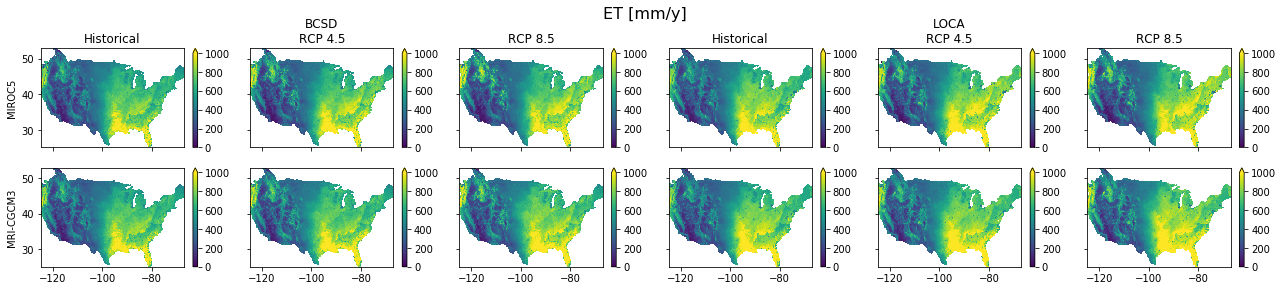

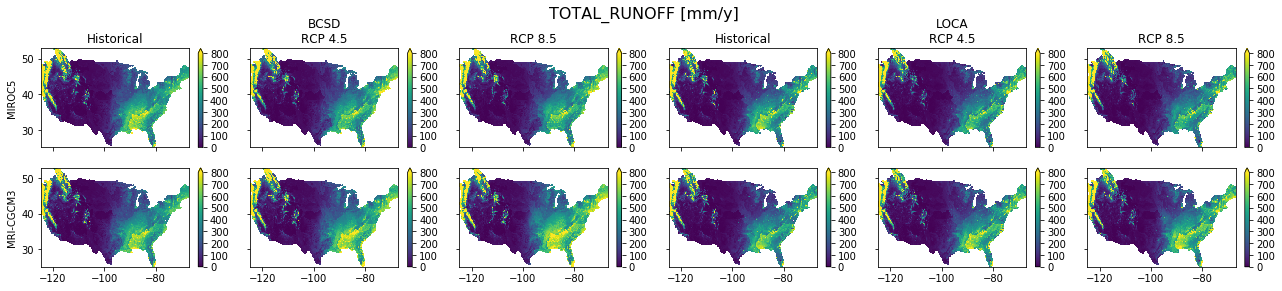

In [38]:
# ens_mean = {}
# ens_snr = {}
# for k, ds in subcols:
#     ens_mean[k] = ds.mean('gcm').persist()
#     ens_std[k] = ds.std('gcm').persist()

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    if '4.5' in title:
                        title = dset.upper() + '\n' + title
                    ax.set_title(title)
                
                ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

#     for i, dset in enumerate(['bcsd', 'loca']):
#         for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
#             ax = axes[-2, col]
#             ens_mean[title][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
    fig.suptitle(var.upper() + ' [mm/y]', fontsize=16, y=1)
    fig.tight_layout()    
#     fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/{var}_mm_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
#     fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_mm_monthly_future_hydro.png', dpi=300, bbox_inches='tight')


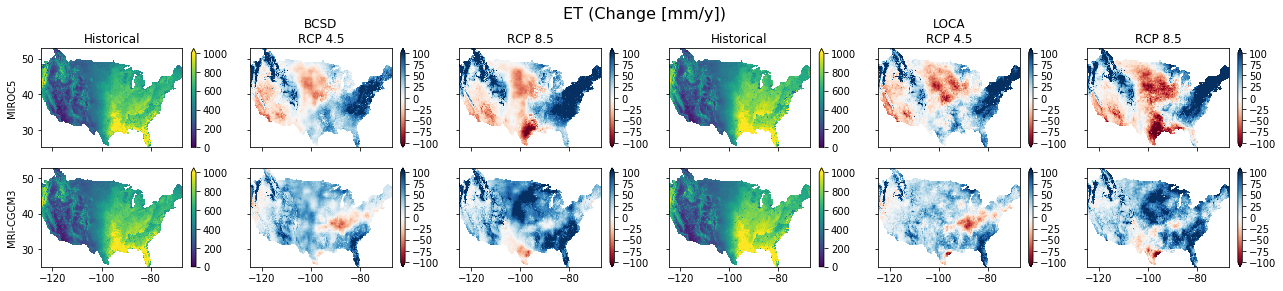

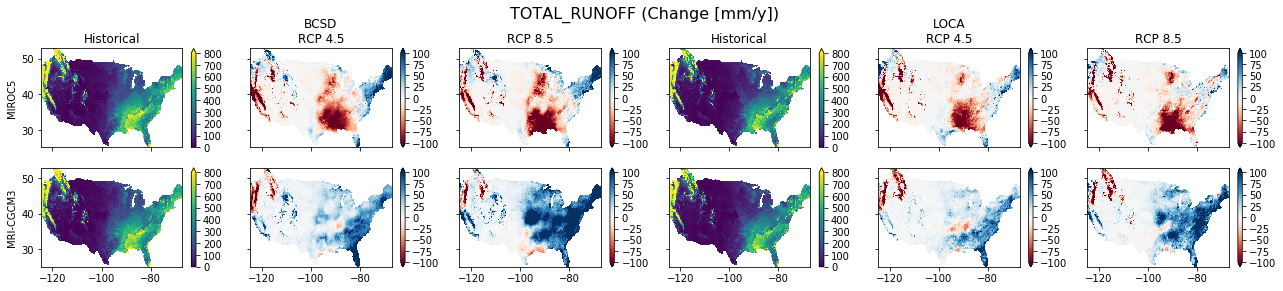

In [11]:
diff_kws = {True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for var in hydro_vars:

    for pct in [False]:
    
        fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
        kws = diff_kws[pct][var]

        for row, model in enumerate(models):
            for i, dset in enumerate(['bcsd', 'loca']):
                for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                    ax = axes[row, col]

                    if col == 0:
                        ax.set_ylabel(model)
                    if row == 0:
                        if '4.5' in title:
                            title = dset.upper() + '\n' + title
                        ax.set_title(title)
                    if 'RCP' in title:
                        calc_change(hist_means[dset][var].sel(gcm=model),
                                    ds_dict[dset][var].sel(gcm=model),
                                    pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **kws)
                    else:
                        ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

        if pct:
            change_str = ' (% Change)'
            unit_str = 'pct'
        else:
            change_str = ' (Change [mm/y])'
            unit_str = 'mm'
        fig.suptitle(var.upper() + change_str, fontsize=16, y=1)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')


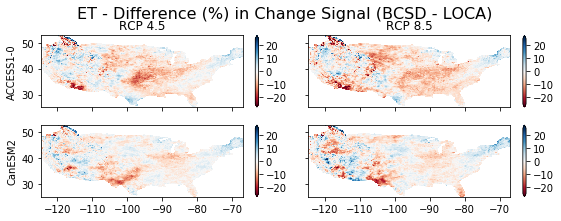

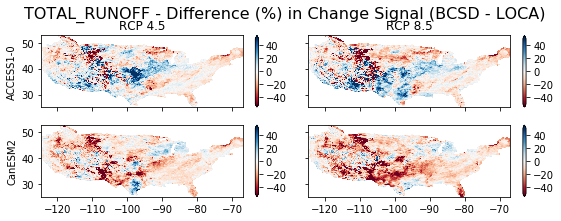

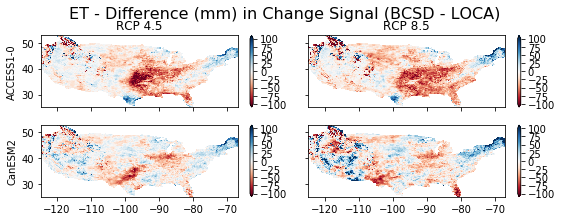

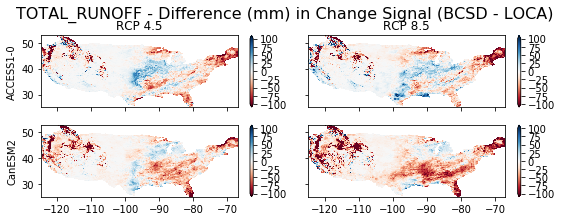

In [9]:

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [True, False]:
    for var in hydro_vars:
        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=2, nrows=len(models), sharex=True, sharey=True, figsize=(8, 1.5*len(models)))

        for row, model in enumerate(models):
            for col, (title, ds_dict) in enumerate(subcols[1:]):

                ax = axes[row, col]

                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)                    

                bcsd_diff = calc_change(ds_dict['bcsd'][var].sel(gcm=model),  hist_means['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(ds_dict['loca'][var].sel(gcm=model),  hist_means['loca'][var].sel(gcm=model), pct=pct)

                (bcsd_diff - loca_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        
        if pct:
            title = var.upper() + " - Difference (%) in Change Signal (BCSD - LOCA)"
            unit_str = 'pct'
        else:
            unit_str = 'mm'
            title = var.upper() + " - Difference (%s) in Change Signal (BCSD - LOCA)" % unit_str
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        

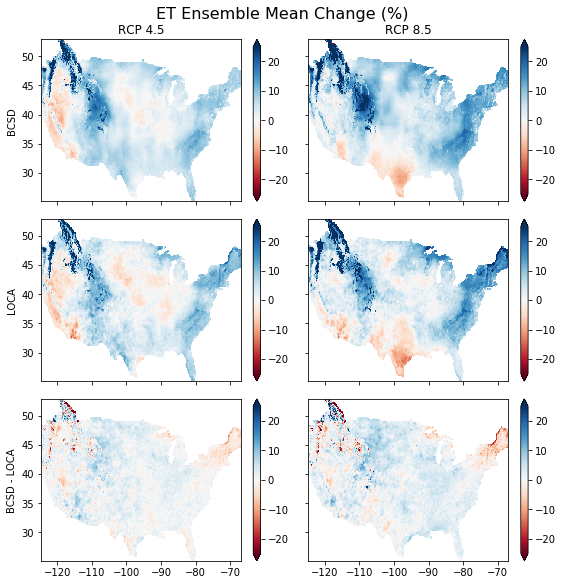

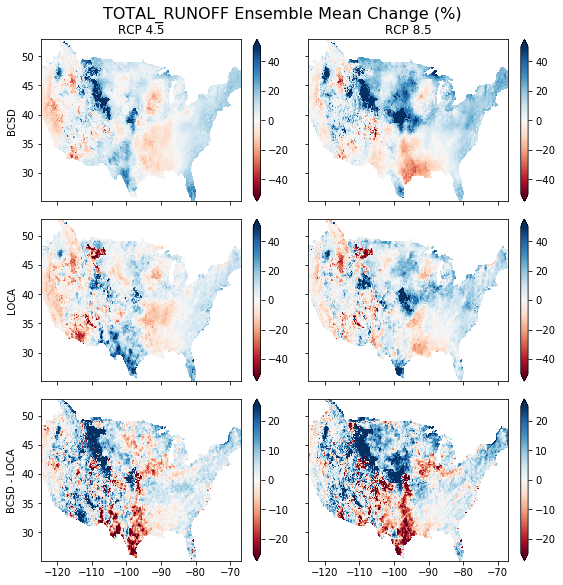

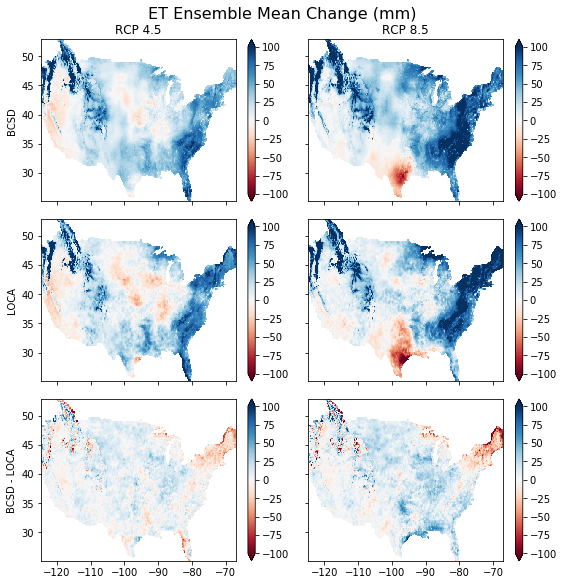

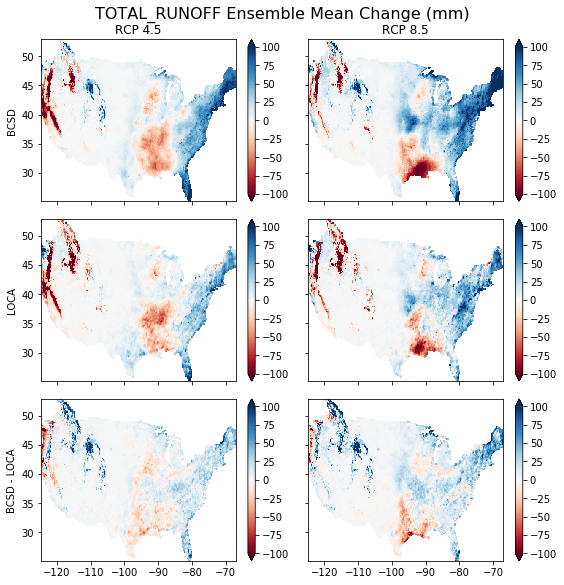

In [13]:
cache = {}

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [True, False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(8, 8))

        for col, (title, dsets) in enumerate(subcols[1:]):

            for row, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(title)
                if col == 0:
                    ax.set_ylabel(dset.upper())

            diff = cache[(row - 1, col)] - cache[(row, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
        axes[-1, 0].set_ylabel('BCSD - LOCA')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/diff3_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        
    

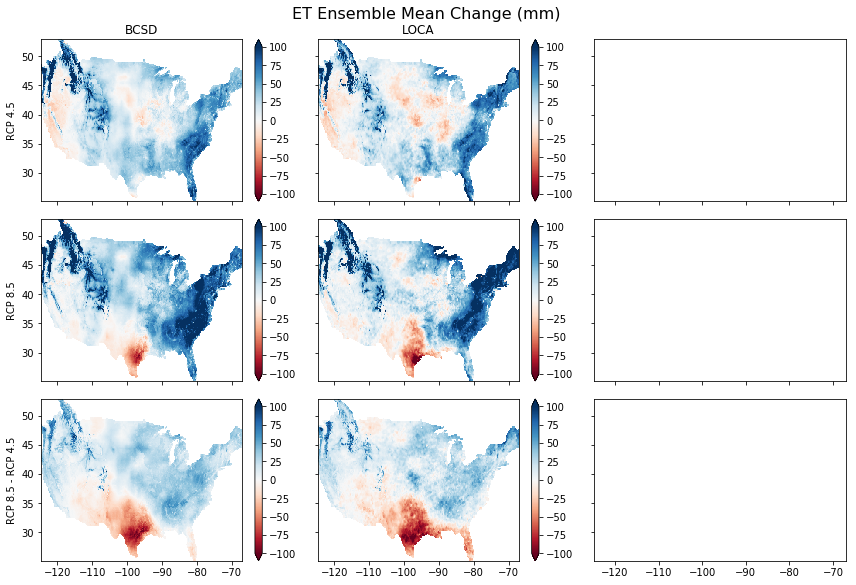

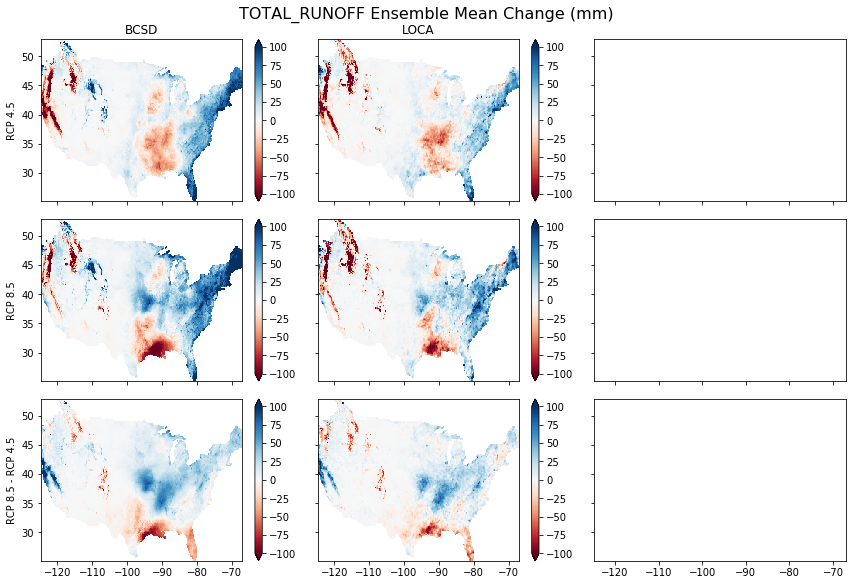

In [20]:
cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff']
# hydro_vars = ['total_runoff']

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for col, dset in enumerate(['bcsd', 'loca']):

            for row, (title, dsets) in enumerate(subcols[1:]):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row - 1, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
            
#             diff2 = cache[(row, col)] - cache[(row, col - 1)]
#             diff2.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

        

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()          
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4b_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        

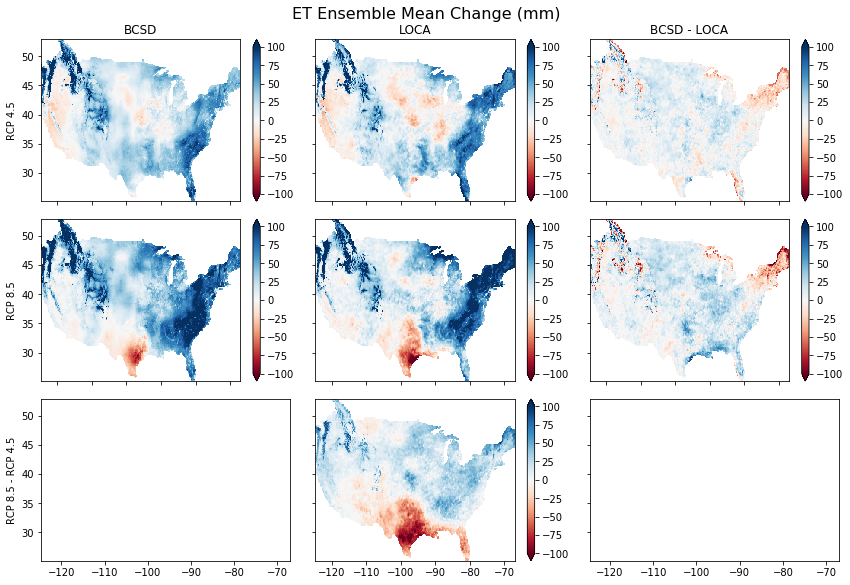

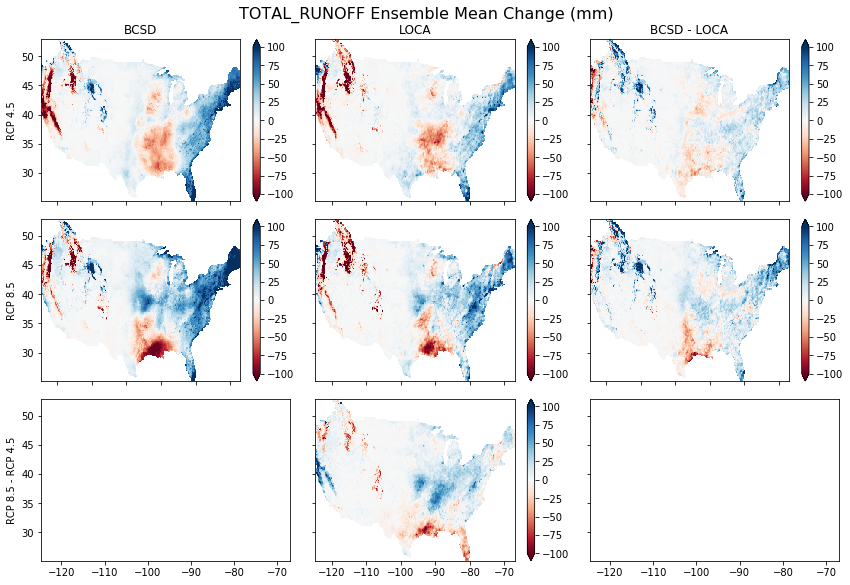

In [12]:
cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff']
# hydro_vars = ['total_runoff']


diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for row, (title, dsets) in enumerate(subcols[1:]):

            for col, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col - 1)] - cache[(row, col)]
            diff.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            axes[0, -1].set_title('BCSD - LOCA')
            
        diff2 = cache[(row, col)] - cache[(row - 1, col)]
        diff2.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])  # only plots second row.  how loop it in?
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4a_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        
    

In [11]:
plt.close('all')